# Data Processing Pipeline - Fixed Version

This notebook processes salary prediction data with proper data leakage prevention and consistent processing.


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


## 1. Load Data


In [5]:
# Load datasets
data_train = pd.read_csv('./Data/salary.train.csv', index_col='id')
data_test = pd.read_csv('./Data/salary.test.csv', index_col='id')
data_live = pd.read_csv('./Data/high_salary.live.csv', index_col='id')

print(f"Training data shape: {data_train.shape}")
print(f"Test data shape: {data_test.shape}")
print(f"Live data shape: {data_live.shape}")


Training data shape: (16720, 18)
Test data shape: (4180, 18)
Live data shape: (6967, 17)


## 2. Define Feature Categories


In [6]:
# Define feature categories
numeric_features = [
    'social-security-number',
    'house-number',
    'fnlwgt'
]

categorical_features = [
    'age-group',
    'education',
    'education-num',
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country-code',
    'native-country',
    'capitalgain',  
    'capitalloss',  
    'hoursperweek' 
]

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {len(categorical_features)} features")


Numeric features: ['social-security-number', 'house-number', 'fnlwgt']
Categorical features: 14 features


## 3. Helper Functions


In [7]:
def count_outliers(series):
    """Count outliers using IQR method"""
    try:
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = series[(series < lower_bound) | (series > upper_bound)]
        return len(outliers), lower_bound, upper_bound
    except Exception as e:
        print(f"Error processing {series.name}: {e}")
        return 0, None, None

def plot_outliers(data, features, title):
    """Plot boxplots for outlier detection"""
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(features, 1):
        plt.subplot(1, len(features), i)
        sns.boxplot(y=data[feature])
        plt.title(f'Boxplot of {feature}')
        plt.ylabel('Value')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def analyze_outliers(data, features, dataset_name):
    """Analyze outliers for given features"""
    print(f"\nOutlier analysis for {dataset_name}:")
    for feature in features:
        count, lower, upper = count_outliers(data[feature])
        if lower is not None and upper is not None:
            print(f"{feature}: {count} outliers (Lower: {lower:.2f}, Upper: {upper:.2f})")
        else:
            print(f"{feature}: Skipped due to error")
    
    plot_outliers(data, features, f"Outlier Analysis - {dataset_name}")


## 4. Initialize Transformers (Fit Only on Training Data)


In [8]:
# Initialize imputers
ssn_imputer = SimpleImputer(strategy='constant', fill_value=0)
other_numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Initialize scaler
scaler = StandardScaler()

print("Transformers initialized successfully")


Transformers initialized successfully


## 5. Process Numeric Features


In [9]:
# Process numeric features for all datasets
def process_numeric_features(train_data, test_data, live_data, numeric_features):
    """Process numeric features consistently across all datasets"""
    
    # Extract numeric features
    train_numeric = train_data[numeric_features].copy()
    test_numeric = test_data[numeric_features].copy()
    live_numeric = live_data[numeric_features].copy()
    
    # Handle missing values
    # SSN: fill with 0
    train_numeric['social-security-number'] = ssn_imputer.fit_transform(
        train_numeric[['social-security-number']]
    ).flatten()
    test_numeric['social-security-number'] = ssn_imputer.transform(
        test_numeric[['social-security-number']]
    ).flatten()
    live_numeric['social-security-number'] = ssn_imputer.transform(
        live_numeric[['social-security-number']]
    ).flatten()
    
    # Other numeric: fill with median
    other_features = ['house-number', 'fnlwgt']
    train_numeric[other_features] = other_numeric_imputer.fit_transform(
        train_numeric[other_features]
    )
    test_numeric[other_features] = other_numeric_imputer.transform(
        test_numeric[other_features]
    )
    live_numeric[other_features] = other_numeric_imputer.transform(
        live_numeric[other_features]
    )
    
    # Apply log transformation to fnlwgt to handle outliers
    train_numeric['fnlwgt'] = np.log1p(train_numeric['fnlwgt'])
    test_numeric['fnlwgt'] = np.log1p(test_numeric['fnlwgt'])
    live_numeric['fnlwgt'] = np.log1p(live_numeric['fnlwgt'])
    
    # Standardize features
    train_numeric_scaled = pd.DataFrame(
        scaler.fit_transform(train_numeric),
        columns=numeric_features,
        index=train_numeric.index
    )
    test_numeric_scaled = pd.DataFrame(
        scaler.transform(test_numeric),
        columns=numeric_features,
        index=test_numeric.index
    )
    live_numeric_scaled = pd.DataFrame(
        scaler.transform(live_numeric),
        columns=numeric_features,
        index=live_numeric.index
    )
    
    return train_numeric_scaled, test_numeric_scaled, live_numeric_scaled

# Process numeric features
train_numeric_processed, test_numeric_processed, live_numeric_processed = process_numeric_features(
    data_train, data_test, data_live, numeric_features
)

print("Numeric features processed successfully")
print(f"Training numeric shape: {train_numeric_processed.shape}")


Numeric features processed successfully
Training numeric shape: (16720, 3)


## 6. Process Categorical Features


In [10]:
# Process categorical features
def process_categorical_features(train_data, test_data, live_data, categorical_features):
    """Process categorical features consistently across all datasets"""
    
    # Extract categorical features
    train_cat = train_data[categorical_features].copy()
    test_cat = test_data[categorical_features].copy()
    live_cat = live_data[categorical_features].copy()
    
    # Handle missing values
    train_cat_imputed = pd.DataFrame(
        categorical_imputer.fit_transform(train_cat),
        columns=categorical_features,
        index=train_cat.index
    )
    test_cat_imputed = pd.DataFrame(
        categorical_imputer.transform(test_cat),
        columns=categorical_features,
        index=test_cat.index
    )
    live_cat_imputed = pd.DataFrame(
        categorical_imputer.transform(live_cat),
        columns=categorical_features,
        index=live_cat.index
    )
    
    # Drop redundant features
    features_to_drop = ['education', 'native-country-code']
    train_cat_imputed = train_cat_imputed.drop(columns=features_to_drop)
    test_cat_imputed = test_cat_imputed.drop(columns=features_to_drop)
    live_cat_imputed = live_cat_imputed.drop(columns=features_to_drop)
    
    return train_cat_imputed, test_cat_imputed, live_cat_imputed

# Process categorical features
train_cat_processed, test_cat_processed, live_cat_processed = process_categorical_features(
    data_train, data_test, data_live, categorical_features
)

print("Categorical features processed successfully")
print(f"Training categorical shape: {train_cat_processed.shape}")


Categorical features processed successfully
Training categorical shape: (16720, 12)


## 7. Feature Engineering


In [11]:
# Lump native-country categories
def lump_native_country(data, top_countries):
    """Lump rare countries into 'Other' category"""
    data['native-country'] = np.where(
        data['native-country'].isin(top_countries),
        data['native-country'],
        'Other'
    )
    return data

# Get top countries from training data only
top_5_countries = train_cat_processed['native-country'].value_counts().index[:5]
print(f"Top 5 countries: {list(top_5_countries)}")

# Apply lumping to all datasets
train_cat_processed = lump_native_country(train_cat_processed, top_5_countries)
test_cat_processed = lump_native_country(test_cat_processed, top_5_countries)
live_cat_processed = lump_native_country(live_cat_processed, top_5_countries)

print("Native country lumping completed")


Top 5 countries: ['united-states', 'mexico', 'philippines', 'germany', 'canada']
Native country lumping completed


## 8. Encoding


In [12]:
# Define features for different encoding strategies
ordinal_features = ['age-group', 'education-num', 'capitalgain', 'capitalloss', 'hoursperweek']
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
lumped_features = ['native-country']

def encode_features(train_cat, test_cat, live_cat):
    """Apply appropriate encoding to categorical features"""
    
    # One-hot encode nominal features
    nominal_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    train_nominal_encoded = pd.DataFrame(
        nominal_encoder.fit_transform(train_cat[nominal_features]),
        columns=nominal_encoder.get_feature_names_out(nominal_features),
        index=train_cat.index
    )
    test_nominal_encoded = pd.DataFrame(
        nominal_encoder.transform(test_cat[nominal_features]),
        columns=nominal_encoder.get_feature_names_out(nominal_features),
        index=test_cat.index
    )
    live_nominal_encoded = pd.DataFrame(
        nominal_encoder.transform(live_cat[nominal_features]),
        columns=nominal_encoder.get_feature_names_out(nominal_features),
        index=live_cat.index
    )
    
    # One-hot encode lumped features
    lumped_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    train_lumped_encoded = pd.DataFrame(
        lumped_encoder.fit_transform(train_cat[lumped_features]),
        columns=lumped_encoder.get_feature_names_out(lumped_features),
        index=train_cat.index
    )
    test_lumped_encoded = pd.DataFrame(
        lumped_encoder.transform(test_cat[lumped_features]),
        columns=lumped_encoder.get_feature_names_out(lumped_features),
        index=test_cat.index
    )
    live_lumped_encoded = pd.DataFrame(
        lumped_encoder.transform(live_cat[lumped_features]),
        columns=lumped_encoder.get_feature_names_out(lumped_features),
        index=live_cat.index
    )
    
    # Combine all encoded features
    train_encoded = pd.concat([
        train_cat[ordinal_features],
        train_nominal_encoded,
        train_lumped_encoded
    ], axis=1)
    
    test_encoded = pd.concat([
        test_cat[ordinal_features],
        test_nominal_encoded,
        test_lumped_encoded
    ], axis=1)
    
    live_encoded = pd.concat([
        live_cat[ordinal_features],
        live_nominal_encoded,
        live_lumped_encoded
    ], axis=1)
    
    return train_encoded, test_encoded, live_encoded

# Apply encoding
train_cat_encoded, test_cat_encoded, live_cat_encoded = encode_features(
    train_cat_processed, test_cat_processed, live_cat_processed
)

print("Categorical features encoded successfully")
print(f"Training encoded shape: {train_cat_encoded.shape}")


Categorical features encoded successfully
Training encoded shape: (16720, 53)


## 9. Combine All Features


In [13]:
# Combine numeric and categorical features
train_processed = pd.concat([train_numeric_processed, train_cat_encoded], axis=1)
test_processed = pd.concat([test_numeric_processed, test_cat_encoded], axis=1)
live_processed = pd.concat([live_numeric_processed, live_cat_encoded], axis=1)

# Add labels back to train and test
train_processed['label'] = data_train['label']
test_processed['label'] = data_test['label']

print(f"Final training data shape: {train_processed.shape}")
print(f"Final test data shape: {test_processed.shape}")
print(f"Final live data shape: {live_processed.shape}")

# Check for any remaining missing values
print("\nMissing values in processed data:")
print(f"Training: {train_processed.isnull().sum().sum()}")
print(f"Test: {test_processed.isnull().sum().sum()}")
print(f"Live: {live_processed.isnull().sum().sum()}")


Final training data shape: (16720, 57)
Final test data shape: (4180, 57)
Final live data shape: (6967, 56)

Missing values in processed data:
Training: 0
Test: 0
Live: 0


## 10. Feature Selection


In [14]:
# Feature selection based on correlation with target
X_train = train_processed.drop(columns=['label'])
y_train = train_processed['label']

# Compute correlation with target
corr_with_label = X_train.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features correlated with label:")
print(corr_with_label.head(10))

# Select features with correlation >= 0.1
threshold = 0.1
selected_features = corr_with_label[corr_with_label >= threshold].index.tolist()
print(f"\nSelected {len(selected_features)} features based on correlation >= {threshold}")

# Remove highly correlated features
corr_matrix = X_train[selected_features].corr().abs()
upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

final_features = [f for f in selected_features if f not in to_drop]
print(f"Dropped {len(to_drop)} redundant features")
print(f"Final feature count: {len(final_features)}")

# Apply feature selection to all datasets
train_final = train_processed[final_features + ['label']]
test_final = test_processed[final_features + ['label']]
live_final = live_processed[final_features]

print(f"\nFinal dataset shapes:")
print(f"Training: {train_final.shape}")
print(f"Test: {test_final.shape}")
print(f"Live: {live_final.shape}")


Top 10 features correlated with label:
marital-status_married-civ-spouse    0.509334
relationship_husband                 0.450938
marital-status_never-married         0.385850
education-num                        0.373260
capitalgain                          0.310260
age-group                            0.293202
relationship_own-child               0.286117
hoursperweek                         0.276753
sex_male                             0.254890
sex_female                           0.254890
dtype: float64

Selected 24 features based on correlation >= 0.1
Dropped 1 redundant features
Final feature count: 23

Final dataset shapes:
Training: (16720, 24)
Test: (4180, 24)
Live: (6967, 23)


## 11. Save Processed Data


In [16]:
# Save processed datasets
train_final.to_csv('./Data/salary.train.processed.csv')
test_final.to_csv('./Data/salary.test.processed.csv')
live_final.to_csv('./Data/salary.live.processed.csv')

print("Successfully saved all processed datasets to './Data/' folder")
print("\nProcessing pipeline completed successfully!")


Successfully saved all processed datasets to './Data/' folder

Processing pipeline completed successfully!


## 12. Summary


=== PROCESSING SUMMARY ===
Original training data shape: (16720, 18)
Final training data shape: (16720, 24)
Features selected: 23
Missing values handled: Yes
Outliers handled: Yes (log transformation for fnlwgt)
Data leakage prevented: Yes
Consistent processing: Yes


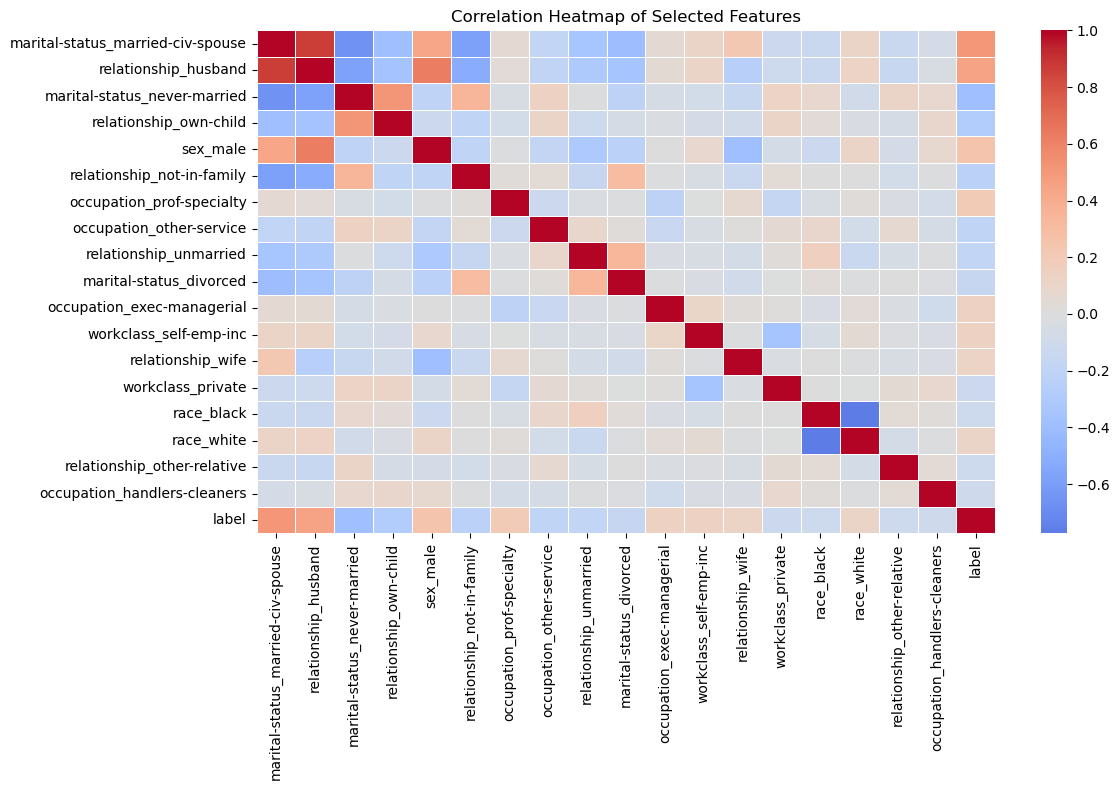

In [17]:
# Display summary
print("=== PROCESSING SUMMARY ===")
print(f"Original training data shape: {data_train.shape}")
print(f"Final training data shape: {train_final.shape}")
print(f"Features selected: {len(final_features)}")
print(f"Missing values handled: Yes")
print(f"Outliers handled: Yes (log transformation for fnlwgt)")
print(f"Data leakage prevented: Yes")
print(f"Consistent processing: Yes")

# Show correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = train_final.corr(numeric_only=True)
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='white'
)
plt.title("Correlation Heatmap of Selected Features")
plt.tight_layout()
plt.show()


In [22]:
train_final

,marital-status_married-civ-spouse,relationship_husband,marital-status_never-married,education-num,capitalgain,age-group,relationship_own-child,hoursperweek,sex_male,relationship_not-in-family,...,capitalloss,occupation_exec-managerial,workclass_self-emp-inc,relationship_wife,workclass_private,race_black,race_white,relationship_other-relative,occupation_handlers-cleaners,label
id,,,,,,,,,,,,,,,,,,,,,
26890,0.0,0.0,0.0,16.0,0.0,3.0,1.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
933,0.0,0.0,0.0,14.0,4.0,3.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
25596,0.0,0.0,1.0,10.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12949,0.0,0.0,0.0,13.0,0.0,2.0,0.0,3.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6681,1.0,1.0,0.0,9.0,0.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,0.0,0.0,1.0,10.0,0.0,0.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2192,1.0,1.0,0.0,10.0,2.0,2.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8250,0.0,0.0,1.0,9.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
